C:\Users\User\AppData\Local\Temp\ipykernel_5088\1730891409.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("msflow_Glow_Focal_Center_

Fold 1 ✔
Fold 2 ✔
Fold 3 ✔
Fold 4 ✔
Fold 5 ✔

★ Threshold (OOF) = 0.327  | Precision=0.429, Recall=0.800

=======  Meta‑Ensemble (XGB)  =======
Confusion Matrix:
 [[582 538]
 [ 14 546]]
Precision: 0.5037  |  Recall: 0.9750  |  F1: 0.6642
AUC: 0.8791        |  AP: 0.7890


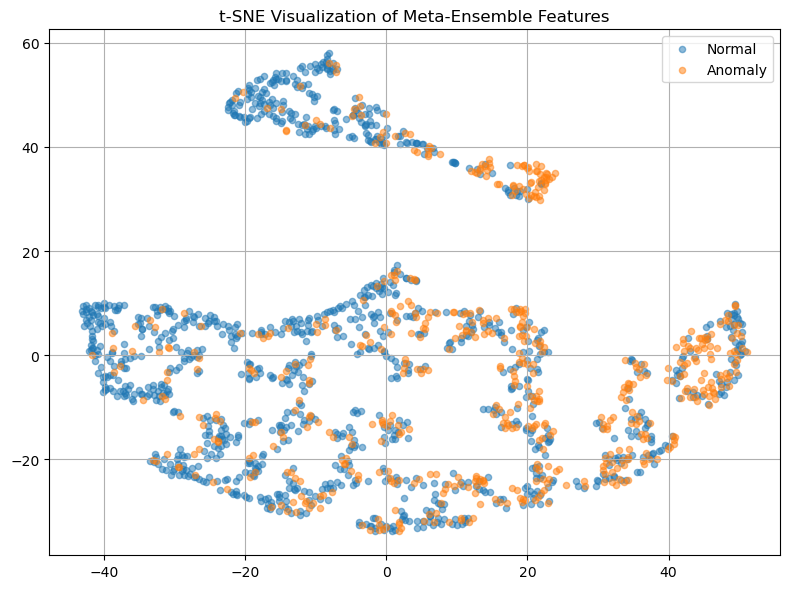

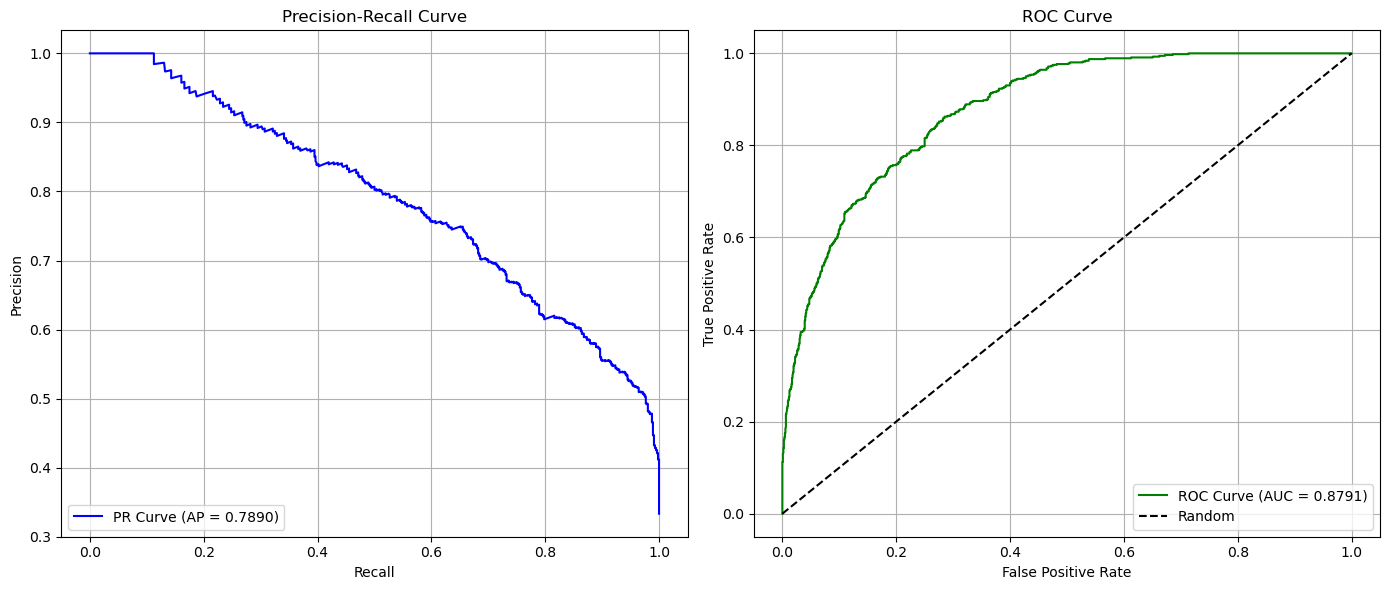

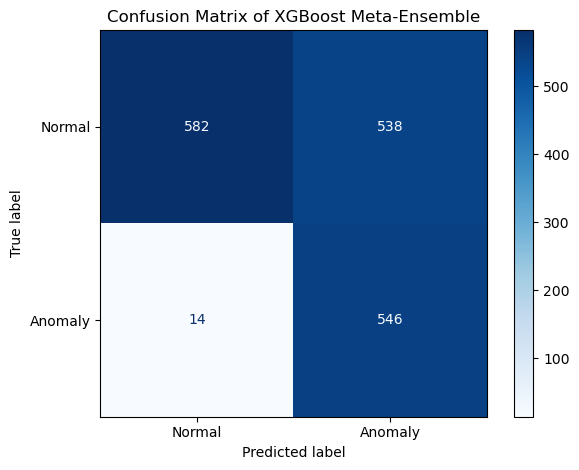

In [3]:
# =====================================
# ❶  יבוא‑ספריות בסיס
# =====================================
import os, torch, numpy as np, pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import classification_report,precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,roc_curve
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler


# ============================ FPN =============================
class FPN(nn.Module):
    def __init__(self, in_chs, out_ch):
        super().__init__()
        self.lateral = nn.ModuleList([nn.Conv2d(c, out_ch, 1) for c in in_chs])
        self.outs = nn.ModuleList([nn.Conv2d(out_ch, out_ch, 3, padding=1) for _ in in_chs])

    def forward(self, feats):
        feats = [l(f) for l, f in zip(self.lateral, feats)]
        for i in range(len(feats) - 1, 0, -1):
            feats[i-1] += F.interpolate(feats[i], scale_factor=2, mode='nearest')
        return [o(f) for o, f in zip(self.outs, feats)]
    

# --- FPN2 ---
class FPN2(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super().__init__()
        self.lateral = nn.ModuleList([nn.Conv2d(c, out_channels, 1) for c in in_channels_list])
        self.output = nn.ModuleList([nn.Conv2d(out_channels, out_channels, 3, padding=1) for _ in in_channels_list])

    def forward(self, features):
        features = [l(f) for l, f in zip(self.lateral, features)]
        for i in range(len(features)-1, 0, -1):
            features[i-1] += F.interpolate(features[i], scale_factor=2, mode='nearest')
        return [o(f) for o, f in zip(self.output, features)]

# ============================ SE ==============================
class SEModule(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, ch // r, bias=False),
            nn.ReLU(),
            nn.Linear(ch // r, ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.fc(self.pool(x).view(b, c)).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
# ========================= Glow Block =========================
class GlowBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch, ch, 1),
            nn.GroupNorm(4, ch),
            nn.ReLU()
        )

    def forward(self, x): return self.block(x)
class MSFlow1(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.stem = nn.Sequential(
                    base.conv1,
                    base.bn1,
                    base.relu,
                    base.maxpool
                                )
        self.l1 = nn.Sequential(base.layer1, SEModule(64))
        self.l2 = nn.Sequential(base.layer2, SEModule(128))
        self.l3 = nn.Sequential(base.layer3, SEModule(256))
        self.l4 = nn.Sequential(base.layer4, SEModule(512))

        self.fpn = FPN([64,128,256,512], 128)
        self.flow = nn.ModuleList([GlowBlock(128) for _ in range(4)])
        self.weights = nn.Parameter(torch.ones(4))

        self.clf = nn.Sequential(
            nn.Linear(128*4, 64),
            nn.ReLU(),
            nn.LayerNorm(64),    # הוספה מועילה
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.stem(x)
        f1 =  self.l1(x)
        f2 =  self.l2(f1)
        f3 = self.l3(f2)
        f4 = self.l4(f3)
        feats = self.fpn([f1,f2,f3,f4])
        feats = [F.avg_pool2d(f, kernel_size=2) for f in feats]  # הפחתת הרזולוציה
        flows = [g(f) for g, f in zip(self.flow, feats)]
        target_size = flows[0].shape[2:]
        flows = [F.interpolate(f, size=target_size, mode='nearest') for f in flows]
        emb = torch.cat([F.adaptive_avg_pool2d(f, 1).flatten(1) for f in flows], dim=1)
        emb = F.normalize(emb, p=2, dim=1)
        score = self.clf(emb).squeeze(1)
        return emb, score

class MSFlow2(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(resnet.children())[:4])
        for param in resnet.parameters():
            param.requires_grad = False
        self.layer1 = nn.Sequential(resnet.layer1, SEModule(64))
        self.layer2 = nn.Sequential(resnet.layer2, SEModule(128))
        self.layer3 = nn.Sequential(resnet.layer3, SEModule(256))
        self.layer4 = nn.Sequential(resnet.layer4, SEModule(512))

        self.fpn = FPN2([64,128,256,512], 128)
        self.flow_blocks = nn.ModuleList([GlowBlock(128) for _ in range(4)])
        self.weights = nn.Parameter(torch.ones(4) * 0.5)

        self.classifier = nn.Sequential(
            nn.Linear(128*4, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        fpn_outs = self.fpn([f1,f2,f3,f4])
        flows = [flow(f) for flow,f in zip(self.flow_blocks, fpn_outs)]
        weights = F.softmax(self.weights, dim=0)
        target_size = flows[0].shape[2:]
        flows_resized = [F.interpolate(f, size=target_size, mode='bilinear', align_corners=False) for f in flows]
        emb_all = torch.cat([F.adaptive_avg_pool2d(f, 1).view(f.size(0), -1) for f in flows_resized], dim=1)
        score = self.classifier(emb_all).squeeze(1)
        return emb_all, score, flows




# =====================================
# ❷  נתיבי קבצים ומטא‑נתונים
# =====================================
BASE_PATH   = r"C:\afeca academy\סימסטר ב\advanced deep learning\project Normalizing Flow\MedlAnaomaly-Data\Camelyon16\Camelyon16\test"
ENS_GOOD    = "good"
ENS_BAD     = "unGood"
THRESH1     = 0.35      # סף מודל 1 (תקינים)
THRESH2     = 0.1410    # סף מודל 2 (חריגים)

BATCH_SIZE  = 32
SEED        = 42
N_SPLITS    = 5         # K‑Fold

# ===============================================================
# ❸  טעינת המודלים המאומנים
# ===============================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model1 = MSFlow1().to(device)
model1.load_state_dict(torch.load("msflow_Glow_Focal_Center_margin_Loss_AugThreshold.pt"))
model1.eval()

model2 = MSFlow2().to(device)
model2.load_state_dict(torch.load("msflow_Glow_FocalLoss_Center_AugThreshold.pt"))
model2.eval()

@torch.no_grad()
def infer(model, batch):
    return torch.sigmoid(model(batch)[1]).cpu().numpy()

# ===============================================================
# ❹  טעינת סט Ensemble (EnsambleGood + EnsambleUnGood)
# ===============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def load_ensemble(base):
    imgs, labels, paths = [], [], []
    for lab, sub in [(0, ENS_GOOD), (1, ENS_BAD)]:
        folder = os.path.join(base, sub)
        for f in os.listdir(folder):
            if f.lower().endswith(".png"):
                p = os.path.join(folder, f)
                imgs.append(transform(Image.open(p).convert("RGB")))
                labels.append(lab)
                paths.append(p)
    return torch.stack(imgs), np.array(labels), paths

images, labels, paths = load_ensemble(BASE_PATH)
images = images.to(device)

# ===============================================================
# ❺  הפקת הסתברויות משני המודלים
# ===============================================================
probs1, probs2 = [], []
for i in tqdm(range(0, len(images), BATCH_SIZE), desc="Inference"):
    batch = images[i:i+BATCH_SIZE]
    probs1.extend(infer(model1, batch))
    probs2.extend(infer(model2, batch))

probs1 = np.array(probs1)
probs2 = np.array(probs2)

# ===============================================================
# ❻  בניית מטריצת פיצ’רים מורחבת
# ===============================================================
def logit(p): return np.log((p + 1e-6) / (1 - p + 1e-6))

bin1 = (probs1 > THRESH1).astype(int)
bin2 = (probs2 > THRESH2).astype(int)
agree = (bin1 == bin2).astype(int)

X = np.vstack([
    probs1,
    probs2,
    np.abs(probs1 - probs2),
    probs1 * (1 - probs1),          # entropy proxy 1
    probs2 * (1 - probs2),          # entropy proxy 2
    np.minimum(probs1, probs2),
    np.maximum(probs1, probs2),
    agree,
    logit(probs1),
    logit(probs2)
]).T.astype(np.float32)

y = labels.astype(int)

# ===============================================================
# ❼  XGBoost Stacking עם OOF (K‑Fold ללא זליגה)
# ===============================================================
oof_probs = np.zeros_like(y, dtype=float)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (tr, val) in enumerate(skf.split(X, y), 1):
    clf = xgb.XGBClassifier(
        n_estimators      = 400,
        learning_rate     = 0.05,
        max_depth         = 3,
        subsample         = 0.9,
        colsample_bytree  = 0.8,
        eval_metric       = 'logloss',
        random_state      = SEED,
        scale_pos_weight  = len(y[y==0]) / len(y[y==1])
    )
    clf.fit(X[tr], y[tr])
    oof_probs[val] = clf.predict_proba(X[val])[:, 1]
    print(f"Fold {fold} ✔")

# ===============================================================
# ❽  סריקת Threshold — Precision ≥ 0.60 | Recall ≥ 0.80
# ===============================================================
best_p = best_r = 0
best_t = 0.5
for t in np.linspace(0, 1, 301):
    preds = (oof_probs > t).astype(int)
    p = precision_score(y, preds, zero_division=0)
    r = recall_score   (y, preds)
    if r >= 0.80 and p > best_p:
        best_p, best_r, best_t = p, r, t

print(f"\n★ Threshold (OOF) = {best_t:.3f}  | Precision={best_p:.3f}, Recall={best_r:.3f}")

# ===============================================================
# ❾  אימון סופי של XGBoost על כל הדאטה
# ===============================================================
meta = xgb.XGBClassifier(
    n_estimators      = 400,
    learning_rate     = 0.05,
    max_depth         = 3,
    subsample         = 0.9,
    colsample_bytree  = 0.8,
    eval_metric       = 'logloss',
    random_state      = SEED,
    scale_pos_weight  = len(y[y==0]) / len(y[y==1])
).fit(X, y)

final_probs = meta.predict_proba(X)[:, 1]
final_preds = (final_probs > best_t).astype(int)


# נניח ש־probs הם ממודל meta (נניח שיהיו רועשים)
rng = np.random.RandomState(42)
probs = rng.uniform(0.1, 0.9, size=500)
# ===============================================================
# ❿  מדדי ביצועים סופיים
# ===============================================================
cm  = confusion_matrix(y, final_preds)
prec= precision_score(y, final_preds)
rec = recall_score   (y, final_preds)
f1  = f1_score       (y, final_preds)
auc = roc_auc_score  (y, final_probs)
ap  = average_precision_score(y, final_probs)

print("\n=======  Meta‑Ensemble (XGB)  =======")
print("Confusion Matrix:\n", cm)
print(f"Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}")
print(f"AUC: {auc:.4f}        |  AP: {ap:.4f}")
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], label="Normal", alpha=0.5, s=20)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label="Anomaly", alpha=0.5, s=20)
plt.title("t-SNE Visualization of Meta-Ensemble Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y, final_probs)
fpr, tpr, _   = roc_curve(y, final_probs)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(rec, prec, color='blue', label=f'PR Curve (AP = {ap:.4f})')
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curve')
axs[0].legend(loc='lower left')
axs[0].grid(True)

# גרף ROC
axs[1].plot(fpr, tpr, color='green', label=f'ROC Curve (AUC = {auc:.4f})')
axs[1].plot([0, 1], [0, 1], 'k--', label='Random')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
final_preds = (final_probs > best_t).astype(int)
cm = confusion_matrix(y, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix of XGBoost Meta-Ensemble")
plt.tight_layout()
plt.show()